# Fintopy #
## *Pandas extensions for financial markets* ##

# Prices module #

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from xbbg import blp
import fintopy

plt.style.use('seaborn-darkgrid')

## Series accessor ##

### *Data* ###

In [2]:
s = blp.bdh('MSFT US Equity', 'PX_LAST', '2020-06-30', '2021-01-31')
s.columns = s.columns.droplevel(1)
s = s.iloc[:, 0]
s.head()

2020-06-30    202.0238
2020-07-01    203.2051
2020-07-02    204.7537
2020-07-06    209.1613
2020-07-07    206.7292
Name: MSFT US Equity, dtype: float64

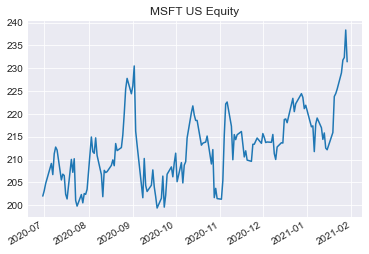

In [3]:
s.plot(title=s.name);

### *Methods* ###

### set_frequency() ###

In [4]:
# Set the frequency of the series to Business Day
bdaily = s.prices.set_frequency()
bdaily.head()

2020-06-30    202.0238
2020-07-01    203.2051
2020-07-02    204.7537
2020-07-03    204.7537
2020-07-06    209.1613
Freq: B, Name: MSFT US Equity, dtype: float64

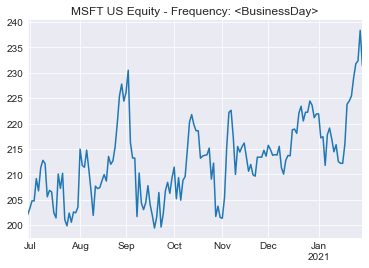

In [5]:
bdaily.plot(title=f'{bdaily.name} - Frequency: {bdaily.index.freq}');

In [6]:
# Set the frequency of the series to Business Week
bweekly = s.prices.set_frequency('BW')
bweekly.head()

2020-07-03    204.7537
2020-07-10    212.1096
2020-07-17    201.3984
2020-07-24    199.8300
2020-07-31    203.5129
Freq: W-FRI, Name: MSFT US Equity, dtype: float64

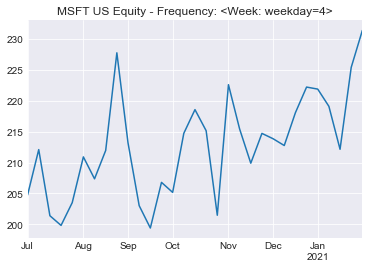

In [7]:
bweekly.plot(title=f'{bweekly.name} - Frequency: {bweekly.index.freq}');

### rebase() ###

In [8]:
# Rebases the series to 100
rebased = s.prices.set_frequency().prices.rebase()
rebased.name = f'{s.name} rebased'
rebased.head()

2020-06-30    100.000000
2020-07-01    100.584733
2020-07-02    101.351276
2020-07-03    101.351276
2020-07-06    103.533000
Freq: B, Name: MSFT US Equity rebased, dtype: float64

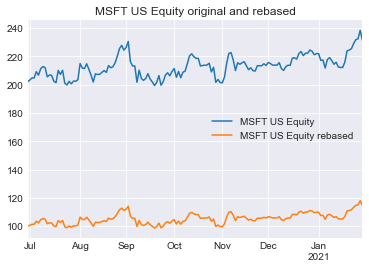

In [9]:
pd.concat((bdaily, rebased), axis=1).plot(title=f'{s.name} original and rebased');

### log_returns() ###

In [10]:
# Daily log returns
lrdaily = s.prices.set_frequency().prices.log_returns()
lrdaily.head()

2020-06-30         NaN
2020-07-01    0.005830
2020-07-02    0.007592
2020-07-03    0.000000
2020-07-06    0.021298
Freq: B, Name: MSFT US Equity, dtype: float64

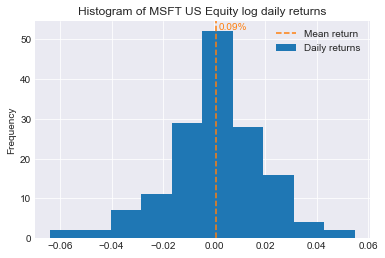

In [11]:
lrdaily.plot.hist(title=f'Histogram of {lrdaily.name} log daily returns', label='Daily returns');
plt.axvline(lrdaily.mean(), color='C1', linestyle='--', label='Mean return');
plt.text(lrdaily.mean() + 0.001, 52.5, f'{lrdaily.mean():.2%}', color='C1');
plt.legend();

### pct_ returns() ###

In [12]:
# Weekly percent returns
prweekly = s.prices.set_frequency('BW').prices.pct_returns()
prweekly.head()

2020-07-03         NaN
2020-07-10    0.035926
2020-07-17   -0.050498
2020-07-24   -0.007788
2020-07-31    0.018430
Freq: W-FRI, Name: MSFT US Equity, dtype: float64

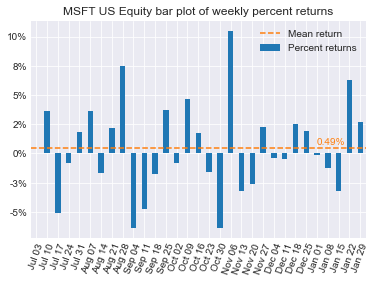

In [13]:
prweekly.plot.bar(title=f'{prweekly.name} bar plot of weekly percent returns', label='Percent returns');
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
plt.gca().xaxis.set_major_formatter(mtick.FixedFormatter(prweekly.index.strftime('%b %d')))
plt.xticks(rotation=70);
plt.axhline(prweekly.mean(), color='C1', linestyle='--', label='Mean return');
plt.text(26, prweekly.mean() + 0.003, f'{prweekly.mean():.2%}', color='C1');
plt.legend();

### abs_return() ###

In [14]:
# Absolute return
print(f'Absolute return: {s.prices.abs_return():.2%}')

Absolute return: 14.55%


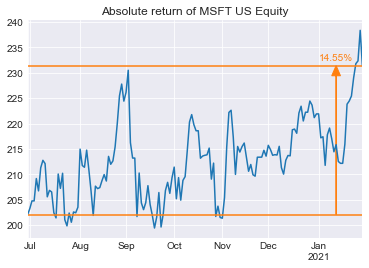

In [15]:
s.prices.set_frequency().plot(title=f'Absolute return of {s.name}');
plt.axhline(s.iat[0], color='C1')
plt.axhline(s.iat[-1], color='C1')
plt.arrow(s.index[-12], s.iat[0], 0, s.iat[-1] - s.iat[0], color='C1', head_width=4, head_length=2, length_includes_head=True);
plt.text(s.index[-12], s.iat[-1] + 1, f'{s.prices.abs_return():.2%}', color='C1', ha='center');

### annualized_return() ###

In [16]:
# Annualized return
print(f'Annualized return: {s.prices.annualized_return():.2%}')

Annualized return: 24.94%


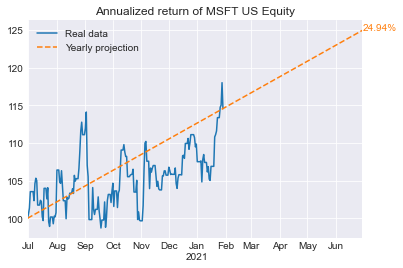

In [17]:
idx = pd.date_range(s.index[0], periods=366)
sreal = s.prices.rebase().reindex(idx).fillna(method='bfill')
sreal.name = 'Real data'
retlin = s.prices.abs_return() / (s.index[-1] - s.index[0]).days * (sreal.index - sreal.index[0]).days
slin = pd.Series(index=idx, data=sreal.iat[0] * (1 + retlin))
slin.name = 'Yearly projection'
pd.concat((sreal, slin), axis=1).plot(title=f'Annualized return of {s.name}', style=['-', '--']);
plt.text(slin.index[-1], slin.iat[-1], f'{s.prices.annualized_return():.2%}', color='C1');

### cagr() ###

In [18]:
# Composite annual growth return
print(f'CAGR: {s.prices.cagr():.2%}')

CAGR: 26.22%


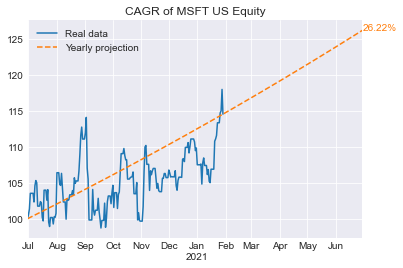

In [19]:
retlog = (1 + s.prices.abs_return()) ** ((sreal.index - sreal.index[0]).days / (s.index[-1] - s.index[0]).days) - 1
slog = pd.Series(index=idx, data=sreal.iat[0] * (1 + retlog))
slog.name = 'Yearly projection'
pd.concat((sreal, slog), axis=1).plot(title=f'CAGR of {s.name}', style=['-', '--']);
plt.text(slog.index[-1], slog.iat[-1], f'{s.prices.cagr():.2%}', color='C1');

### drawdown() e max_drawdown() ###

In [24]:
# Calculates the drawdown
dd = s.prices.set_frequency().prices.drawdown(negative=True)
dd.head()

2020-06-30   -0.0
2020-07-01   -0.0
2020-07-02   -0.0
2020-07-03   -0.0
2020-07-06   -0.0
Freq: B, Name: MSFT US Equity, dtype: float64

In [25]:
# Max drawdown
print(f'CAGR: {s.prices.max_drawdown(negative=True):.2%}')

CAGR: -13.49%


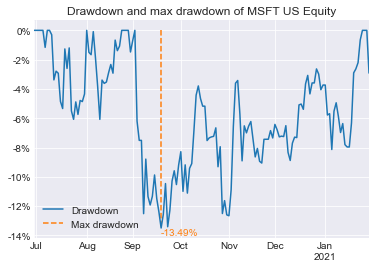

In [38]:
dd.plot(title=f'Drawdown and max drawdown of {dd.name}', label='Drawdown');
ddate = dd.idxmin()
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
plt.vlines(ddate, 0, s.prices.max_drawdown(negative=True), color='C1', linestyle='--', label='Max drawdown');
plt.text(ddate, s.prices.max_drawdown(negative=True) - 0.005, f'{s.prices.max_drawdown(negative=True):.2%}', color='C1');
plt.legend();